# Exploring Anchoring
This notebook is for doing initial explorations of how to investigate anchoring / in general conduct psychological experiments on large language models

In [63]:
import openai
import json
import numpy as np
import random
import asyncio
import pandas as pd

In [173]:
def read_json(filename: str) -> dict:
    with open(filename) as f:
        return json.load(f)

        
def get_api_key(config, keyname: str = "goose_api") -> str:
    """
    Gets the API key from the config file.
    """
    return read_json(config)[keyname]
    
def authenticate_goose(config) -> None:
    """
    Authenticates with the goose API.
    """
    api_key = get_api_key(config, keyname="goose_api")
    openai.api_key = api_key
    openai.api_base = "https://api.goose.ai/v1"

def generate_prompt(
    prompt: str, model_name: str = "gpt-neo-125m", max_tokens: int = 75, temperature=0.9
) -> str:
    """
    Generates a prompt using a model from EleutherAI.
    """
    return openai.Completion.create(
        prompt=prompt,
        engine=model_name,
        max_tokens=max_tokens,
        temperature=temperature,
    )["choices"][0]["text"]


In [4]:
api_key = read_json('config.json')['goose_api']

In [5]:
test_question = "Height of Mount Everest (in feet):"

In [6]:
# generate random integer between 1 and 100
true_height = 29031.7
low_num = random.randint(2000, 5000)
high_num = random.randint(50_000, 100_000)

In [7]:
q_prompt = f"{low_num}\n{test_question}"
print(q_prompt)

3566
Height of Mount Everest (in feet):


In [12]:
authenticate_goose('config.json')

In [17]:
answer = generate_prompt(q_prompt, max_tokens=10)

In [184]:
import re
def find_first_num(s: str):
    """
    Finds first integer or floating point in string
    """
    clean_s = s.replace(',', '')
    try: 
        return re.findall(r"[-+]?(?:\d*\.\d+|\d+)", clean_s)[0]
    except IndexError:
        return None


In [25]:
N = 10
answers = [None for _ in range(N)]
for i in range(N):
    #num = random.randint(2000, 5000)
    num = random.randint(50_000, 100_000)
    q_prompt = f"Random number: {num}\n{test_question}"
    answer = generate_prompt(q_prompt, max_tokens=10)
    answers[i] = answer

In [36]:
# numpy log numbers between 1 and 1_000_000
N = 3
log_nums = np.logspace(3, 5, num=10, base=10, dtype=int)
answer_dict = dict.fromkeys(log_nums)
for num in log_nums:
    prompt_list = []
    for i in range(N):
        q_prompt = f"Random number: {num}\n{test_question}"
        answer = generate_prompt(q_prompt, max_tokens=10)
        prompt_list.append(answer)
    answer_dict[num] = prompt_list


In [141]:
def create_prompt(num: int, question: str = test_question) -> str:
    """
    Creates a prompt for the given number.
    """
    return f"Random number: {num}\n{test_question}"

In [92]:
# async requests with the goose API
async def get_answer(num: int, model_type="fairseq-6-7b") -> str:
    """
    Gets an answer from the goose API.
    """
    q_prompt = create_prompt(num)
    result = generate_prompt(q_prompt, max_tokens=10, model_name=model_type)
    return result

In [42]:
result = asyncio.gather(*[get_answer(log_nums[0]) for _ in range(3)])

In [93]:
# numpy log numbers between 1 and 1_000_000
N = 10
log_nums = np.logspace(3, 5, num=10, base=10, dtype=int)
answer_dict = dict.fromkeys(log_nums)
for num in log_nums:
    answer = asyncio.gather(*[get_answer(num) for _ in range(N)])
    answer_dict[num] = answer

In [94]:
new_dict = {k: v.result() for k, v in answer_dict.items()}

In [95]:
newer_dict = {k: [find_first_num(i) for i in v] for k, v in new_dict.items()}

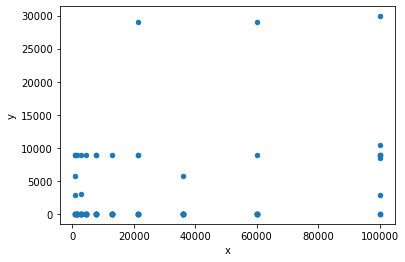

In [105]:
df = pd.concat({k: pd.Series(v) for k, v in newer_dict.items()}).reset_index().dropna()
df.columns = ["x", "ignore", "y"]
df.drop(columns=["ignore"], inplace=True)
df["y"] = df["y"].astype(float)
df.plot(x="x", y="y", kind="scatter")
df.rename(columns={"x": "anchor", "y": "model_answer"}, inplace=True)

In [106]:
df.to_csv("output/fairseq-6-7b_everest_answer.csv")

## Exploring multiple prompts

In [230]:
from typing import List

async def generate_n_prompts(
    prompt, n_completions: int = 1, model_name: str = "gpt-neo-125m", max_tokens: int = 5, temperature=0.9
):
    """
    Generates a prompt using a model from EleutherAI.
    """
    return openai.Completion.create(
        prompt=prompt,
        engine=model_name,
        n = n_completions,
        max_tokens=max_tokens,
        temperature=temperature,
    )

testy = await asyncio.gather(*[generate_n_prompts("Height of Mount Everest (in feet):", n_completions=10, model_name="gpt-j-6b") for num in log_nums])

In [231]:
testy

[<OpenAIObject text_completion id=6d1623d8-9508-42a3-b1bd-73d553eba0f3 at 0x1775b4aa450> JSON: {
   "choices": [
     {
       "finish_reason": "length",
       "index": 0,
       "logprobs": {
         "text_offset": [
           0,
           3,
           5,
           6,
           7
         ],
         "tokens": [
           " 88",
           "48",
           "m",
           "bytes:'\\n'",
           "bytes:'\\n'"
         ]
       },
       "text": " 8848m\n\n",
       "token_index": 0
     },
     {
       "finish_reason": "length",
       "index": 1,
       "logprobs": {
         "text_offset": [
           0,
           3,
           4,
           7,
           10
         ],
         "tokens": [
           " 29",
           ",",
           "028",
           " ft",
           " ("
         ]
       },
       "text": " 29,028 ft (",
       "token_index": 0
     },
     {
       "finish_reason": "length",
       "index": 2,
       "logprobs": {
         "text_offset": [
       

In [232]:
[i.text for x in testy for i in x.choices]

[' 8848m\n\n',
 ' 29,028 ft (',
 ' 8,848 and',
 '\n\n13811\n',
 ' 8850\n\nIndust',
 ' 8,516 feet (',
 ' 6,189 Feet\n',
 ' 8848\n\n7',
 ' 8,848 feet',
 ' " + summitHeight);',
 ' 29,007 feet (',
 '\nBy personal observation,',
 ' 8848\nHeight of',
 ' 8848\n\nAverage',
 ' 29,027 ft.',
 ' 8,850\n\n',
 ' 8,851m',
 '\nElizabeth Peak: 8',
 ' 85,848The',
 ' \nHeight of Everest',
 ' 29201.35 (',
 ' 29,035 (Google',
 ' 8,848 M',
 ' 8848\n\nHeight',
 ' 8848-9023',
 '\n\n5,445',
 ' 8848.11\n',
 ' 8848\n\nHeight',
 ' 1,700mi,',
 ' 8848\n\nWeight',
 ' 8848 [@p',
 ' 8,848 m',
 '\n\nElevation',
 ' 8,848 ft',
 ' 8,848m',
 ' 8848 ft\n\n',
 ' 8,848ft',
 ' 8,848 feet',
 ' 8,848 ft',
 ' 8,848\n',
 ' 8,823,',
 ' 8664<|endoftext|>',
 ' 8,848\n',
 ' 8848\n\nHeight',
 '\n\nThe highest peak',
 '\n\nReference:\n',
 ' 57, 872\n',
 ' 8,848 feet',
 '** Up to 8,',
 '\n\nHeight of Mount',
 ' 29,035\n\n',
 ' 17,520\nMed',
 ' 8,848 ft',
 '\n\nHeight of Mount',
 ' 8,848.',
 ' 8848\n\n1996',
 ' 8,848ft',
 '\n\nGreatest he

In [200]:
test_prompts = [create_prompt(num) for num in log_nums]
N_REP = 20
testytest_fairseq = generate_prompts(test_prompts, n_completions=N_REP, model_name="fairseq-6-7b")

In [201]:
anchors = np.repeat(log_nums, N_REP)
answers = [result.text for result in testytest_fairseq.choices]
float_answers = [find_first_num(answer) for answer in answers]

<AxesSubplot:xlabel='anchor', ylabel='model_answer'>

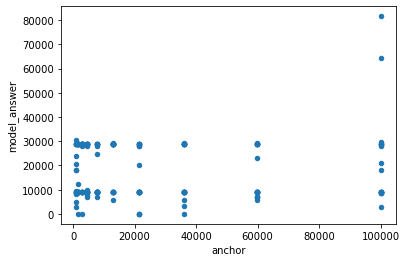

In [202]:
new_df = pd.DataFrame({"anchor": anchors, "model_answer": float_answers}).dropna()
new_df["model_answer"] = new_df["model_answer"].astype(float)
new_df[new_df["model_answer"] < 100_000].plot(x="anchor", y="model_answer", kind="scatter")

In [203]:
new_df.to_csv("output/fairseq-6-7b_everest_answer_2.csv", index=False)